# **UNIT 2 SPRINT 1 MODULE 4**

You'll use a dataset of 400+ burrito reviews. How accurately can you predict whether a burrito is rated 'Great'?

We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- Begin with baselines for classification.
- Use scikit-learn for logistic regression.
- Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- Get your model's test accuracy. (One time, at the end.)
- Commit your notebook to your fork of the GitHub repo.

## **STRETCH**

- Make exploratory visualizations.
- Do one-hot encoding.
- Do feature scaling.
- Get and plot your coefficients.
- Try scikit-learn pipelines.
- Make your own stretch goals!

In [0]:
%%capture
!pip install category_encoders==2.*

In [0]:
import pandas as pd
pd.set_option('display.max_rows', 100)
path = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/burritos/burritos.csv'
df = pd.read_csv(path)

In [0]:
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# high cardinality
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

# "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


### **1. TRAIN/VAL/TEST**

In [0]:
dateDT = pd.to_datetime(df['Date'], infer_datetime_format=True)

pre17 = dateDT.dt.year < 2017
post17 = dateDT.dt.year > 2017
at17 = ~pre17 & ~post17

df_whole = df.copy()
df_train = df_whole[pre17]
df_val = df_whole[at17]
df_test = df_whole[post17]

In [0]:
print(df_train.shape)
df_train.head()

(298, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
print(df_val.shape)
df_val.head()

(85, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,1/4/2017,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,1/4/2017,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,1/7/2017,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,1/7/2017,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,1/10/2017,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [0]:
print(df_test.shape)
df_test.head()

(38, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,4/25/2026,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,1/2/2018,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,1/9/2018,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,1/12/2018,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,1/12/2018,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


### **1¾. PREPROCESS DATA**

Includes one-hot encoding & feature scaling

In [0]:
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

enc = ce.one_hot.OneHotEncoder(cols=['Burrito'], use_cat_names=True)
enc.fit(df_whole)

# ...

def preprocess(df_original):
  
  df = df_original.copy()

  # save some random date stuff, just not the actual date
  dateDT = pd.to_datetime(df['Date'], infer_datetime_format=True)
  df['Date_Year'] = dateDT.dt.year.astype(np.float64)
  df['Date_Month'] = dateDT.dt.month.astype(np.float64)
  df['Date_Week'] = dateDT.dt.week.astype(np.float64)
  df['Date_YearDay'] = dateDT.dt.dayofyear.astype(np.float64)
  df['Date_MonthDay'] = dateDT.dt.day.astype(np.float64)
  df['Date_WeekDay'] = dateDT.dt.dayofweek.astype(np.float64)
  df = df.drop('Date', axis=1)

  # not all columns are useful, drop some here
  df = df.drop(columns=[
      'Queso', 'Yelp', 'Google', 'Mass (g)', 'Density (g/mL)'
  ])

  # fill some missing values w/ averages
  fill_w_avg = ['Cost', 'Hunger', 'Length', 'Circum', 'Volume',
                'Temp', 'Meat', 'Fillings', 'Meat:filling',
                'Uniformity', 'Salsa', 'Synergy', 'Wrap']
  for col in fill_w_avg:
    df[col] = df[col].fillna(df[col].mean())
  
  # convert those 'x'/NaN columns to 1, 0
  wonky_vectors = ['Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
                   'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
                   'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper',
                   'Carrots', 'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
                   'Onion', 'Taquito', 'Pineapple', 'Ham', 'Chile relleno',
                   'Nopales', 'Lobster', 'Egg', 'Mushroom', 'Bacon', 'Sushi',
                   'Avocado', 'Corn', 'Zucchini', 'Chips']
  nos = ['No']
  yeses = ['x', 'X', 'Yes']
  for col in wonky_vectors:
    df[col] = df[col].fillna(0)
    df[col] = df[col].replace(nos, 0)
    df[col] = df[col].replace(yeses, 1)
    df[col] = df[col].astype(np.float64)

  # better column names
  df = df.rename(columns={
      
      # meta
      'Cost': 'Meta_Cost',
      'Hunger': 'Meta_Hunger',
      'Length': 'Meta_Length',
      'Circum': 'Meta_Circum',
      'Volume': 'Meta_Volume',
      
      # ratings
      'Tortilla': 'Tortilla_Rating',
      'Temp': 'Temp_Rating',
      'Meat': 'Meat_Rating',
      'Fillings': 'Fillings_Rating',
      'Meat:filling': 'Meat_Fillings_Rating',
      'Uniformity': 'Uniformity_Rating',
      'Salsa': 'Salsa_Rating',
      'Synergy': 'Synergy_Rating',
      'Wrap': 'Wrap_Rating',

      # toppings
      'Unreliable': 'Unreliable_Topping',
      'NonSD': 'NonSD_Topping',
      'Beef': 'Beef_Topping',
      'Pico': 'Pico_Topping',
      'Guac': 'Guac_Topping',
      'Cheese': 'Cheese_Topping',
      'Fries': 'Fries_Topping',
      'Sour cream': 'Sour_Cream_Topping',
      'Pork': 'Pork_Topping',
      'Chicken': 'Chicken_Topping',
      'Shrimp': 'Shrimp_Topping',
      'Fish': 'Fish_Topping',
      'Rice': 'Rice_Topping',
      'Beans': 'Beans_Topping',
      'Lettuce': 'Lettuce_Topping',
      'Tomato': 'Tomato_Topping',
      'Bell peper': 'Bell_Pepper_Topping',
      'Carrots': 'Carrots_Topping',
      'Cabbage': 'Cabbage_Topping',
      'Sauce': 'Sauce_Topping',
      'Salsa.1': 'Salsa_Topping',
      'Cilantro': 'Cilantro_Topping',
      'Onion': 'Onion_Topping',
      'Taquito': 'Taquito_Topping',
      'Pineapple': 'Pineapple_Topping',
      'Ham': 'Ham_Topping',
      'Chile relleno': 'Chile_Relleno_Topping',
      'Nopales': 'Nopales_Topping',
      'Lobster': 'Lobster_Topping',
      'Egg': 'Egg_Topping',
      'Mushroom': 'Mushroom_Topping',
      'Bacon': 'Bacon_Topping',
      'Sushi': 'Sushi_Topping',
      'Avocado': 'Avocado_Topping',
      'Corn': 'Corn_Topping',
      'Zucchini': 'Zucchini_Topping',
      'Chips': 'Chips_Topping'
  })

  # one-hot encode Burrito
  df = enc.transform(df)
  df['Burrito_California'] = df['Burrito_California'].astype(np.float64)
  df['Burrito_Carnitas'] = df['Burrito_Carnitas'].astype(np.float64)
  df['Burrito_Asada'] = df['Burrito_Asada'].astype(np.float64)
  df['Burrito_Other'] = df['Burrito_Other'].astype(np.float64)
  df = df.rename(columns={'Burrito_Surf & Turf': 'Burrito_Surf_Turf'})
  df['Burrito_Surf_Turf'] = df['Burrito_Surf_Turf'].astype(np.float64)

  # split into features & target matrices
  target = 'Great'
  features = df.columns.drop(target)
  X = df[features]
  y = df[target].astype(np.float64)

  # normalize X
  normer = StandardScaler()
  X = normer.fit_transform(X)
  X = pd.DataFrame(X, columns=features)

  return X, y

In [0]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(preprocess)

In [0]:
X_train, y_train = transformer.transform(df_train)
X_val, y_val = transformer.transform(df_val)
X_test, y_test = transformer.transform(df_test)

In [0]:
X_train.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf_Turf,Chips_Topping,Meta_Cost,Meta_Hunger,Meta_Length,Meta_Circum,Meta_Volume,Tortilla_Rating,Temp_Rating,Meat_Rating,Fillings_Rating,Meat_Fillings_Rating,Uniformity_Rating,Salsa_Rating,Synergy_Rating,Wrap_Rating,Unreliable_Topping,NonSD_Topping,Beef_Topping,Pico_Topping,Guac_Topping,Cheese_Topping,Fries_Topping,Sour_Cream_Topping,Pork_Topping,Chicken_Topping,Shrimp_Topping,Fish_Topping,Rice_Topping,Beans_Topping,Lettuce_Topping,Tomato_Topping,Bell_Pepper_Topping,Carrots_Topping,Cabbage_Topping,Sauce_Topping,Salsa_Topping,Cilantro_Topping,Onion_Topping,Taquito_Topping,Pineapple_Topping,Ham_Topping,Chile_Relleno_Topping,Nopales_Topping,Lobster_Topping,Egg_Topping,Mushroom_Topping,Bacon_Topping,Sushi_Topping,Avocado_Topping,Corn_Topping,Zucchini_Topping,Date_Year,Date_Month,Date_Week,Date_YearDay,Date_MonthDay,Date_WeekDay
0,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-0.282330,-0.339805,-0.524307,0.0,0.0,0.0,-0.593162,1.340696,-0.645992,-0.022447,0.458224,0.557478,0.721245,0.500993,0.038686,-0.315644,-0.130632,0.879664,1.041113,1.069526,1.0,1.226459,-0.631713,-0.410643,-0.268221,-0.268221,-0.130632,-0.352886,-0.346844,-0.195774,-0.155097,-0.155097,-0.058026,-0.155097,-0.376514,-0.143346,-0.230225,-0.245964,-0.116642,-0.155097,-0.058026,-0.116642,-0.116642,-0.058026,-0.116642,-0.100844,-0.100844,-0.082199,-0.213574,-0.082199,-0.058026,0.068323,-1.882428,-1.821830,-1.860737,0.131133,-1.514145
1,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-0.282330,-1.208571,0.064423,0.0,0.0,0.0,-1.849023,-0.213867,-1.231964,-1.202403,-1.486989,0.557478,0.187274,-1.133401,0.899679,-0.315644,-0.130632,0.879664,1.041113,1.069526,1.0,1.226459,-0.631713,-0.410643,-0.268221,-0.268221,-0.130632,-0.352886,-0.346844,-0.195774,-0.155097,-0.155097,-0.058026,-0.155097,-0.376514,-0.143346,-0.230225,-0.245964,-0.116642,-0.155097,-0.058026,-0.116642,-0.116642,-0.058026,-0.116642,-0.100844,-0.100844,-0.082199,-0.213574,-0.082199,-0.058026,0.068323,-1.882428,-1.821830,-1.792710,0.782424,1.586990
2,-0.809664,4.503967,-0.364801,-0.764922,-0.27534,-0.282330,-1.709783,-2.290496,0.0,0.0,0.0,-0.593162,-1.768429,-1.231964,-0.612425,0.944528,0.557478,-0.346697,-0.588603,0.899679,-0.315644,-0.130632,-1.136797,1.041113,1.069526,-1.0,-0.815355,-0.631713,2.435207,-0.268221,-0.268221,-0.130632,-0.352886,-0.346844,-0.195774,-0.155097,-0.155097,-0.058026,-0.155097,-0.376514,-0.143346,-0.230225,-0.245964,-0.116642,-0.155097,-0.058026,-0.116642,-0.116642,-0.058026,-0.116642,-0.100844,-0.100844,-0.082199,-0.213574,-0.082199,-0.058026,0.068323,-1.882428,-1.821830,-1.792710,0.782424,1.586990
3,-0.809664,-0.222027,2.741220,-0.764922,-0.27534,-0.282330,-1.375642,-1.701766,0.0,0.0,0.0,-0.593162,-1.768429,-0.060021,-0.612425,0.458224,1.480371,0.721245,0.500993,0.899679,-0.315644,-0.130632,0.879664,1.041113,1.069526,-1.0,-0.815355,-0.631713,-0.410643,-0.268221,-0.268221,-0.130632,-0.352886,-0.346844,-0.195774,-0.155097,-0.155097,-0.058026,-0.155097,-0.376514,-0.143346,-0.230225,-0.245964,-0.116642,-0.155097,-0.058026,-0.116642,-0.116642,-0.058026,-0.116642,-0.100844,-0.100844,-0.082199,-0.213574,-0.082199,-0.058026,0.068323,-1.882428,-1.821830,-1.792710,0.782424,1.586990
4,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,3.541956,-0.256270,0.653153,0.0,0.0,0.0,0.662698,1.340696,0.525950,-0.022447,0.944528,1.480371,-0.880668,1.045791,0.038686,-0.315644,-0.130632,0.879664,1.041113,-0.934994,1.0,1.226459,-0.631713,-0.410643,-0.268221,-0.268221,-0.130632,-0.352886,-0.346844,-0.195774,-0.155097,-0.155097,-0.058026,-0.155097,-0.376514,-0.143346,-0.230225,-0.245964,-0.116642,-0.155097,-0.058026,-0.116642,-0.116642,-0.058026,-0.116642,-0.100844,-0.100844,-0.082199,-0.213574,-0.082199,-0.058026,0.068323,-1.882428,-1.742724,-1.758696,1.108070,-0.480433


In [0]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

everything = Pipeline([
    ('preproc', FunctionTransformer(preprocess)),
    ('dum_cls', DummyClassifier(strategy='prior'))
])

In [0]:
everything.fit(df_train[df_train.columns.drop('Great')], df_train['Great'])
everything.score(df_val[df_val.columns.drop('Great')], df)

### **2. BASELINE MODEL**

In [0]:
from sklearn.dummy import DummyClassifier

dummy_cls = DummyClassifier(strategy='prior')
dummy_cls.fit(X_train, y_train)

print('MAJORITY BASELINE')
print('Training Accuracy ::', dummy_cls.score(X_train, y_train))
print('Validation Accuracy ::', dummy_cls.score(X_val, y_val))
print('Test Accuracy ::', dummy_cls.score(X_test, y_test))

MAJORITY BASELINE
Training Accuracy :: 0.5906040268456376
Validation Accuracy :: 0.5529411764705883
Test Accuracy :: 0.42105263157894735


In [0]:
# just to be sure...
print('Training Majority ::', y_train.value_counts(normalize=True)[0.0])
print('Validation Majority ::', y_val.value_counts(normalize=True)[0.0])
print('Testing Majority ::', y_test.value_counts(normalize=True)[0.0])

Training Majority :: 0.5906040268456376
Validation Majority :: 0.5529411764705883
Testing Majority :: 0.42105263157894735


### **3. LOGISTIC REGRESSION**

In [0]:
from sklearn.linear_model import LogisticRegression

logreg_cls1 = LogisticRegression()
logreg_cls1.fit(X_train, y_train)
logreg_cls1.score(X_val, y_val)

0.8470588235294118

In [0]:
logreg_cls1.score(X_test, y_test)

0.6842105263157895

### **4. PLOTTING COEFFICIENTS**

In [0]:
logreg_cls1.intercept_

array([-1.61583706])

In [0]:
logreg_cls1.coef_

array([[ 5.29899302e-01, -2.19206837e-01, -4.78635525e-02,
        -6.16920403e-01,  3.92079403e-01, -2.16780911e-02,
         4.10269979e-01,  3.54197036e-01,  1.20730715e-01,
        -1.96847281e-02,  1.78055594e-01,  7.24093456e-01,
         8.00778852e-01,  1.77920282e+00,  1.20535712e+00,
         1.36479447e+00,  1.94312492e-01,  7.13247391e-02,
         1.85753677e+00,  1.54568993e-01,  2.36056125e-01,
         6.36666571e-02, -5.76250203e-01, -1.81943963e-01,
         3.81438137e-01, -9.36463649e-02, -3.67460585e-01,
         9.51599906e-02,  3.79980814e-01, -2.04124902e-01,
        -2.72454662e-01,  1.64902688e-02,  2.09560218e-01,
        -7.82507915e-01, -2.39073005e-01, -3.00977644e-01,
        -1.99527856e-01, -1.25387306e-02,  5.66155753e-03,
        -6.82400977e-03,  1.30780598e-01,  2.23126965e-01,
         7.59488939e-02, -4.40710061e-04, -7.97316822e-01,
         4.18999798e-01,  1.82783638e-01,  1.93718522e-01,
        -5.48343009e-02,  2.82470868e-02,  1.80416253e-0

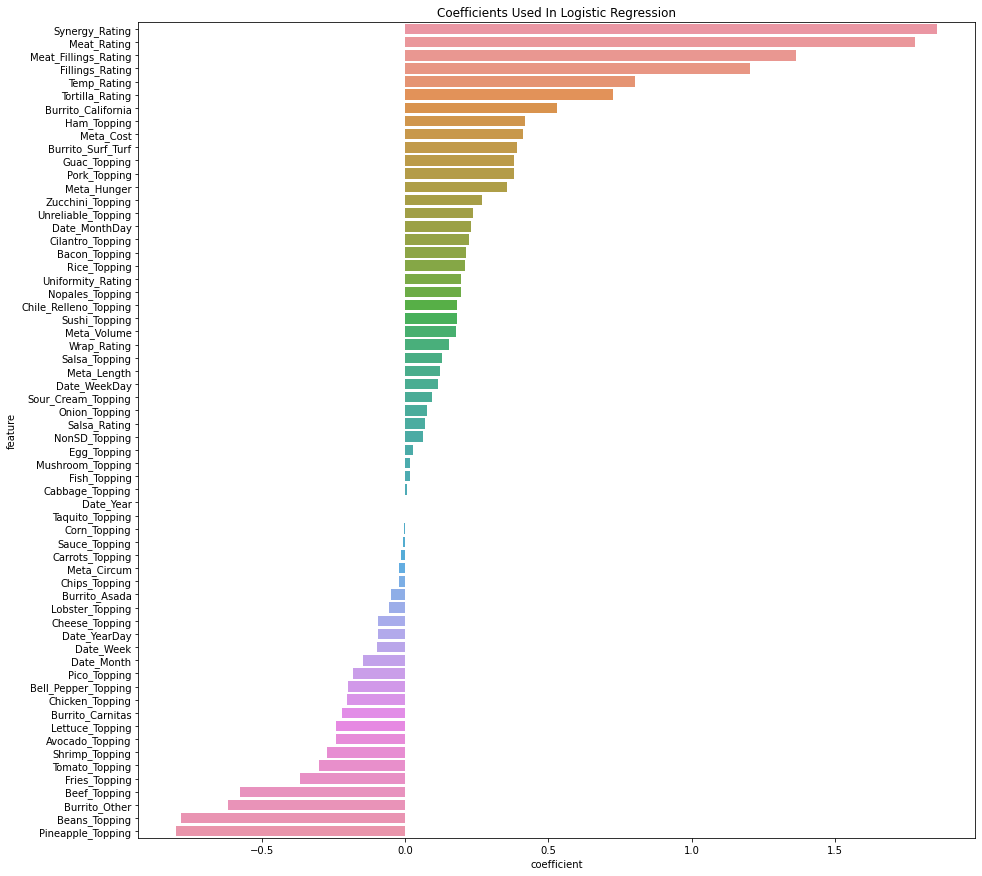

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
points = list(zip(X_train.columns, logreg_cls1.coef_[0]))
feats, data = zip(*sorted(points, key=lambda _:_[1], reverse=True))
jesus_df = pd.DataFrame({
    'feature':feats,
    'coefficient':data
})
fig, ax = plt.subplots(figsize=(15,15))
thingy = sns.barplot(x='coefficient', y='feature', data=jesus_df, ax=ax)
thingy.set_title('Coefficients Used In Logistic Regression')
plt.show()

### **SCRATCH**

In [0]:
# columns without any missing values
[c for c in df_whole.columns if df_whole[c].isnull().sum() == 0]

['Burrito', 'Date', 'Tortilla', 'Great']

In [0]:
# columns with no values at all
[c for c in df_whole.columns if df_whole[c].isnull().sum() == df_whole.shape[0]]

['Queso']

In [0]:
# rows with null cost
df_whole[df_whole['Cost'].isnull()]

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
112,Other,4/20/2015,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
134,Other,5/19/2016,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,NaN,3.8,4.0,NaN,4.7,NaN,5.0,NaN,4.7,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
257,Other,10/17/2016,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.5,4.2,4.7,4.4,4.0,4.9,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
265,Other,10/27/2016,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
266,Other,10/27/2016,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
267,Other,10/27/2016,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,3.0,2.0,2.0,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
316,California,2/21/2017,NaN,NaN,NaN,NaN,4.3,NaN,NaN,18.5,21.5,0.68,3.0,3.0,3.5,4.0,3.0,1.5,3.8,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# averages of some missing columns
for c in ['Cost', 'Hunger', 'Length', 'Circum', 'Volume']:
  print(c, df_whole[c].mean())
  print(df_whole.groupby('Burrito')[c].mean())
  print()

Cost 7.067342995169068
Burrito
Asada          6.514419
California     7.008750
Carnitas       6.237200
Other          7.226400
Surf & Turf    8.157143
Name: Cost, dtype: float64

Hunger 3.4953349282296653
Burrito
Asada          3.469767
California     3.588095
Carnitas       3.438000
Other          3.486452
Surf & Turf    3.062963
Name: Hunger, dtype: float64

Length 20.038233215547702
Burrito
Asada          19.948276
California     20.195714
Carnitas       19.368421
Other          19.954388
Surf & Turf    20.305556
Name: Length, dtype: float64

Circum 22.13576512455516
Burrito
Asada          21.292857
California     22.285805
Carnitas       21.500000
Other          22.081378
Surf & Turf    23.430556
Name: Circum, dtype: float64

Volume 0.7864768683274022
Burrito
Asada          0.727500
California     0.800678
Carnitas       0.713684
Other          0.782143
Surf & Turf    0.885556
Name: Volume, dtype: float64



In [0]:
print(df_whole.shape)
df_whole.isnull().sum()

(421, 59)


Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 